
# Slim simulations



In [1]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

np.random.seed(7)

Import variables global to the entire analysis:

In [2]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [3]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

Ignore warnings:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [6]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load swept regions

In [7]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_10['chrom'] = 'chrX'
(extended_peak_regions_10.end_pos - extended_peak_regions_10.start_pos).sum()

31900000

## TMRCA computations

In [66]:
from math import exp

def lamb(i):
    # lamb(i) rate of coalescence from i-1 to i
    i += 1
    return i*(i-1)/2

samples = 5 # total samples
setsize = 3 # size of clade (we want to see at least one such clade coalesce before time t)
t = 1

for n in range(setsize, samples+1):
    # loop from setsize to samples (3 to 5):
    p = 0
    for i in range(1, n):
        # loop from 1 to n-1:
        p += np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j]) \
        * exp(-lamb(n)*t) \
        * (lamb(i)/(lamb(i)-lamb(n))) \
        * (-exp(-(lamb(i)-lamb(n))*t) + 1)
    # combinatorial expression:
    p *= scipy.misc.comb(n, setsize) / scipy.misc.comb(samples, setsize)
p
    


0.035592882340661172

In [36]:
def lamb(x):
    x += 1
    return x*(x-1)/2


N = 3000
n = 42
t = 1

prob = 0
for i in range(1, n):
    prob += (1 - math.exp(-lamb(i)*t)) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j])
prob * scipy.misc.comb(140, 42)

1.5316066224579469e+35

In [31]:
scipy.misc.comb(140, 42)

1.0163968567466686e+36

In [19]:
1- math.exp(-lamb(1))

0.6321205588285577

In [123]:
def lamb(x):
    return x*(x-1)/2

t = 10
n = 20

prob = 0
for i in range(1, n+1):
    print([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
    prob += lamb(i) * math.exp(-lamb(i)*t) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
prob #* scipy.misc.comb(n, i)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[-0.0, 1.5, 1.2, 1.1111111111111112, 1.0714285714285714, 1.05, 1.037037037037037, 1.0285714285714285, 1.0227272727272727, 1.0185185185185186, 1.0153846153846153, 1.0129870129870129, 1.011111111111111, 1.0096153846153846, 1.0084033613445378, 1.0074074074074073, 1.006578947368421, 1.0058823529411764, 1.0052910052910053]
[-0.0, -0.5, 2.0, 1.4285714285714286, 1.25, 1.1666666666666667, 1.12, 1.0909090909090908, 1.0714285714285714, 1.0576923076923077, 1.0476190476190477, 1.04, 1.0340909090909092, 1.0294117647058822, 1.0256410256410255, 1.0225563909774436, 1.02, 1.0178571428571428, 1.0160427807486632]
[-0.0, -0.2, -1.0, 2.5, 1.6666666666666667, 1.4, 1.2727272727272727, 1.2, 1.1538461538461537, 1.1224489795918366, 1.1, 1.0833333333333333, 1.0705882352941176, 1.0606060606060606, 1.0526315789473684, 1.0461538461538462, 1.0408163265306123, 1.0363636363636364, 1.0326086956521738]
[-0.0, -0.1111111111111

0.0

In [121]:
lamb(3)

3.0

In [99]:
import scipy

def coal_n_to_l(n, l, t):
    """Prob of reducing n lineages to l in time t"""
    Q = np.zeros(shape=(n-l+1, n-l+1))
    for x in range(n-l):
        rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
        Q[x][x] = -rate
        Q[x][x+1] = rate
    return scipy.linalg.expm(Q*t)[0][-1]

def clade_prob(n, l, t, i):
    """Prob of one among l lineages being ancestor to i among n"""
#     if i == 1 or l == 1:
#         return 1
#     else:
    return scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)
        
n = 5
t = 36
pop_size = 300
i = 2

total_prop = 0
for l in range(1, n):
    total_prop += coal_n_to_l(n, l, t) * clade_prob(n, l, t, i)
total_prop

0.1403635580926885

In [80]:
        
        
n = 5
t = 360
pop_size = 30

i = 2

#l = 3

total_prop = 0

for l in [3]:#range(1, n):
    
    # probability of having l out of n left at time t
    Q = np.zeros(shape=(n-l+1, n-l+1))
    for x in range(n-l):
        rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
        Q[x][x] = -rate
        Q[x][x+1] = rate
    prop_coalescences_n_to_l = scipy.linalg.expm(Q*t)[0][-1]
    prop_coalescences_n_to_l

    
    if i == 1 or l == 1:
        prop_ancestor_to_i = 1 # CHECK THAT THIS IS OK
    else:
        prop_ancestor_to_i = scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)

    assert prop_ancestor_to_i <= 1, prop_ancestor_to_i

    prob = prop_coalescences_n_to_l * prop_ancestor_to_i

    print(prop_coalescences_n_to_l, prop_ancestor_to_i)

    total_prop += prob
total_prop

1.0 0.333333333333


0.33333333333333315

In [81]:
Q

array([[-0.16666667,  0.16666667,  0.        ],
       [ 0.        , -0.1       ,  0.1       ],
       [ 0.        ,  0.        ,  0.        ]])

## Extract likely pi relative to global pi in Africans

In [8]:
dist_afr = (pd.read_hdf(ag.steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.store')
            .loc[lambda df: (df.region_1 == 'Africa') & (df.region_2 == 'Africa')]
           )
dist_afr.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,...,longitude_1,longitude_2,sex_1,sex_2,region_label_1,region_label_2,region_id_1,region_id_2,region_1,region_2
16348768,X,0,100000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.000000,0,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa
16348769,X,100000,200000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.003137,4,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa
16348770,X,200000,300000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.002749,6,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa
16348771,X,300000,400000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.002136,8,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa
16348772,X,400000,500000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.001950,5,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa


In [9]:
afr_mean_dist = dist_afr.dist.mean()

In [10]:
lst = list()
for tup in extended_peak_regions_10.itertuples():
    lst.append(dist_afr.loc[(dist_afr.start >= tup.start_pos) & (dist_afr.end <= tup.end_pos)])
dist_regions = pd.concat(lst)
dist_regions.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,...,longitude_1,longitude_2,sex_1,sex_2,region_label_1,region_label_2,region_id_1,region_id_2,region_1,region_2
16348876,X,10800000,10900000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.000407,31,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa
16348877,X,10900000,11000000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.000154,12,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa
16348878,X,11000000,11100000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.000248,19,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa
16348879,X,11100000,11200000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.000333,27,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa
16348880,X,11200000,11300000,NA,B_Ju_hoan_North-4,A,B_Dinka-3,A,0.000773,59,...,27.4,21.452448,XY,XY,Africa,Africa,0,0,Africa,Africa


In [11]:
afr_mean_dist_in_regions = dist_regions.dist.mean()

In [12]:
afr_mean_dist_in_regions, afr_mean_dist, afr_mean_dist_in_regions / afr_mean_dist

(0.00054783799920951409, 0.00074873561921252267, 0.73168416882009535)

## Compute demographies

In [19]:
sim_generations = 200000 - 1
x_auto_fraction = 0.55

def years2gen(y):
    return int(1 + sim_generations - y / ag.gen_time)

years2gen(sim_generations * ag.gen_time), years2gen(0), sim_generations * ag.gen_time

(1, 200000, 5799971)

In [20]:
changes_year = [sim_generations * ag.gen_time, 250000, 150000, 100000, 70000, 50000, 35000, 25000, 15000, 6000]
changes_Ne = [20000, 12000, 6000, 4000, 3000, 4000, 6000, 12000, 20000, 100000]
sweep_years = [30000, 50000, 70000, 100000]

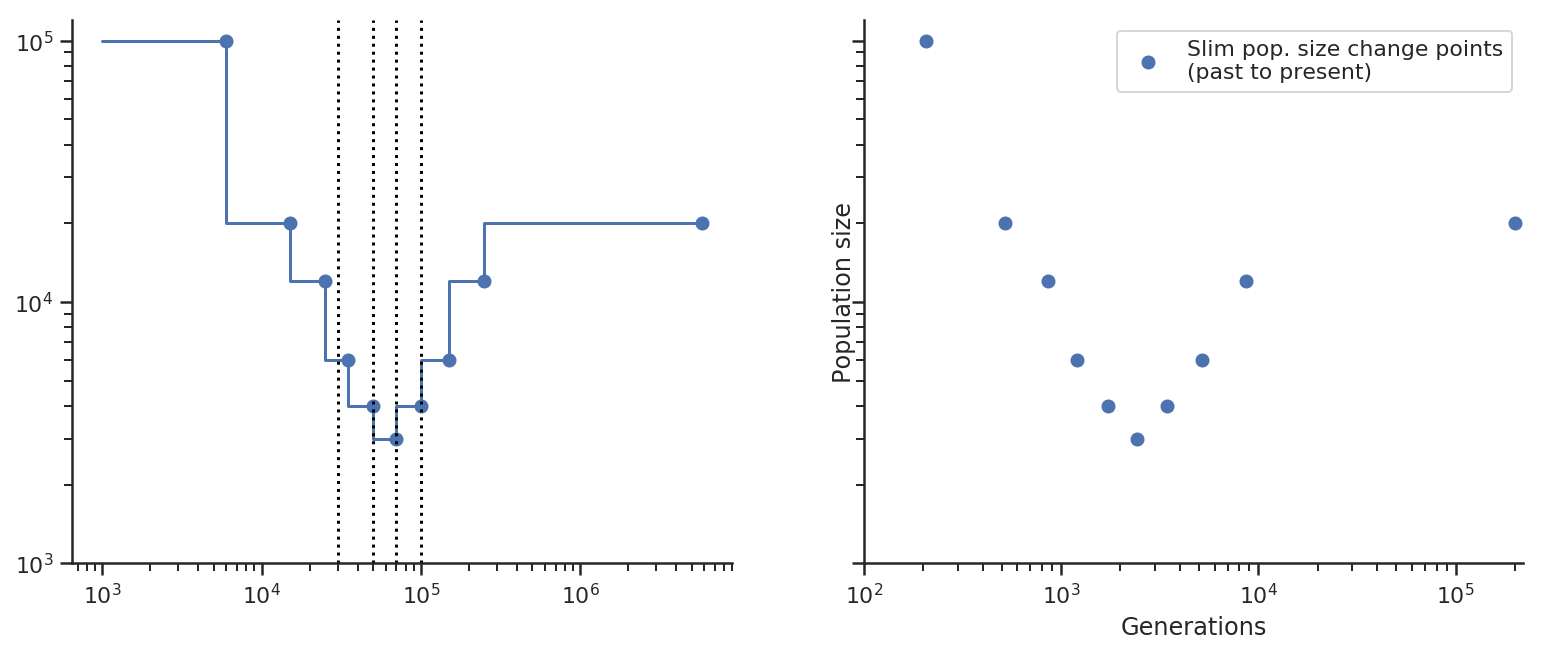

In [21]:
with sns.axes_style('ticks') :

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5), sharey=True)

    y = Series(list(reversed(changes_year)))
    n = Series(list(reversed(changes_Ne)))
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

    auto_demography = list(zip(reversed(x[1::2]), reversed(y[1::2])))

    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color)
    ax1.loglog(*list(zip(*auto_demography)), marker='o', color=color, linestyle='None', label='Autosomes');


    y = Series(list(reversed(changes_year)))
    n = Series(list(reversed(changes_Ne))) * x_auto_fraction
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

#     x_demography = [(y, n*x_auto_fraction) for (y, n) in auto_demography]

#     color=next(ax1._get_lines.prop_cycler)['color']
#     ax1.loglog(x, y, color=color)
#     ax1.loglog(*list(zip(*x_demography)), marker='o', color=color, linestyle='None', label='X');
#     ax1.set_ylim(1000, 120000)
#     ax1.set_xlim(1e3, 1e7) ;
#     ax1.set_xlabel('Years')
#     ax1.set_ylabel('Population size')
#     ax1.legend()

    [ax1.axvline(x, linestyle='dotted', color='black') for x in sweep_years]
    
    
    
    slim_demography = [(years2gen(y), int(n)) for (y, n) in auto_demography]  ## using auto
    g, n = list(zip(*slim_demography))
    ax2.loglog([sim_generations-x for x in g], n, marker='o', linestyle='None', 
               label='Slim pop. size change points\n(past to present)');
    ax2.set_ylim(1000, 120000)
    ax2.set_xlim(1e2, 2.2e5) ;
    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Population size')
    ax2.legend()

    sns.despine()

We use **autosomal** sizes for Slim because it models the X chrom explicitly. To make the X/A ratio lower than 0.75 we scale the population sizes by (e.g. 0.66/0.75) when running the slim simulation.

Generation-Ne pairs for changeing population size in Slim simulation (for adding to `workflow.py`):

In [24]:
slim_demography

[(1, 20000),
 (191379, 12000),
 (194827, 6000),
 (196551, 4000),
 (197586, 3000),
 (198275, 4000),
 (198793, 6000),
 (199137, 12000),
 (199482, 20000),
 (199793, 100000)]

Generations for sweeps in Slim simulations (for adding to `workflow.py`):

In [25]:
sweep_generations = [years2gen(x) for x in sweep_years]
sweep_generations

[198965, 198275, 197586, 196551]

In [26]:
# sim_generations = 100000

# def years2gen(y):
#     return int(sim_generations - y / 29)
    
    
# def demography(pop_size, bottle_pop_size, bottle_start, bottle_end):
    
#     def bottleneck_N(t):
#         return int(round(t / (1/bottle_pop_size - (1-t)/pop_size)))

#     t = Series([1, 2/3, 1/3])
#     demog = DataFrame(dict(bottle_pop_size=t.map(bottleneck_N), 
#                                    bottle_time=t*(bottle_start - bottle_end)))
#     demog['bottle_start'] = round(bottle_start - (bottle_start - bottle_end - demog.bottle_time) / 2).astype(int)
#     demog['bottle_end'] = round(bottle_end + (bottle_start - bottle_end - demog.bottle_time) / 2).astype(int)
#     demog['pop_size'] = pop_size
#     return demog

# smallest_x_auto_fraction = 0.5
# pop_size = int(20000 * smallest_x_auto_fraction)
# bottle_pop_size = int(2000 * smallest_x_auto_fraction)
# bottle_start = 100000
# bottle_end = 30000

# demog = pd.concat([demography(10000, 1000, 100000, 30000),
#                   # demography(20000, 2000, 100000, 30000)
#                   ])
# demog

Print for loading into `workflow.py`:

In [27]:
# list(zip(
#     list(demog.pop_size),
#     list(years2gen(x) for x in demog.bottle_start),
#     list(years2gen(x) for x in demog.bottle_end),
#     demog.bottle_pop_size))

## Pool-Nielsen computation

In [28]:

epoques = list()
g, n = list(zip(*slim_demography))
gens, Ns = [sim_generations-x for x in g][::-1], n[::-1]
for i in range(len(gens)):
    if i == 0:
        epoques.append((gens[i], Ns[i]))
    elif i == len(gens) - 1:
        epoques.append((None, Ns[i]))    
    else:
        epoques.append((gens[i] - gens[i-1], Ns[i]))
epoques


[(206, 100000),
 (311, 20000),
 (345, 12000),
 (344, 6000),
 (518, 4000),
 (689, 3000),
 (1035, 4000),
 (1724, 6000),
 (3448, 12000),
 (None, 20000)]

In [29]:
def exp_coal(g, N):
    return 2*N - (g * np.exp(-g/(2*N))) / (1 - np.exp(-g/(2*N)))

def epoch(demog, h, i):
    g, N = demog[i]
    N *= h
    if i == len(demog)-1:
        return 2*N
    return (1-np.exp(-g/(2*N))) * exp_coal(g, N) + np.exp(-g/(2*N)) * (g + epoch(demog, h, i+1))

#epoques = [(1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (None, 1000)]

african_x_auto_ratio = 0.66 * 0.73
pool_nielsen_ratio = epoch(epoques, african_x_auto_ratio, 0) / epoch(epoques, 1, 0)
pool_nielsen_ratio

0.34880824716238862

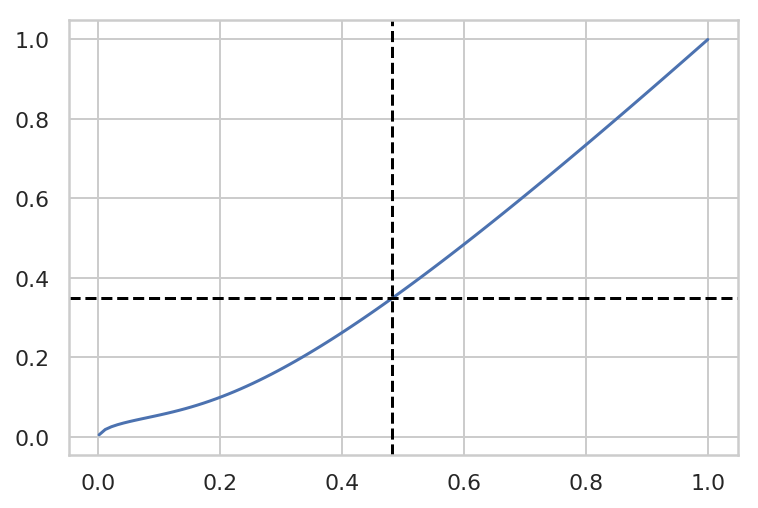

In [30]:
x = np.linspace(0.001, 1, 100)
y = [epoch(epoques, h, 0) / epoch(epoques, 1, 0) for h in x]
plt.plot(x, y) ;
plt.axvline(african_x_auto_ratio, color='black', linestyle='dashed')
plt.axhline(pool_nielsen_ratio, color='black', linestyle='dashed') ;

## Lift over regions to hg38

In [11]:
extended_peak_regions_10.head()

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,swept_indivs,chrom
0,11300000.0,11200000,11400000,0.357143,10800000,11700000,0.078571,"['S_Hazara-1', 'S_Kinh-2', 'S_Naxi-1', 'S_Papu...",chrX
1,14750000.0,14700000,14800000,0.421429,14200000,15200000,0.142857,"['S_Ami-1', 'S_Japanese-3', 'S_Jordanian-2', '...",chrX
2,19850000.0,19800000,19900000,0.828571,19300000,20600000,0.314286,"['S_Hezhen-1', 'S_Kinh-2', 'S_Yadava-2']",chrX
3,21250000.0,21200000,21300000,0.821429,20500000,21700000,0.314286,"['B_Australian-4', 'S_Adygei-1', 'S_Armenian-1...",chrX
4,36250000.0,36200000,36300000,0.671429,35700000,37100000,0.085714,['S_Tujia-1'],chrX


In [12]:
print(extended_peak_regions_10.loc[lambda df: df.peak_prop_swept >= 0.5, 
                                   ['chrom', 'start_pos', 'end_pos']].to_string(index=False))

chrom  start_pos    end_pos
chrX   19300000   20600000
chrX   20500000   21700000
chrX   35700000   37100000
chrX   37200000   37800000
chrX   49400000   50300000
chrX   53400000   54900000
chrX   62500000   63900000
chrX   63800000   65300000
chrX   72300000   73600000
chrX   73700000   74900000
chrX   76700000   77800000
chrX   98200000   99400000
chrX  109100000  111600000
chrX  113600000  114700000
chrX  126000000  127700000
chrX  129500000  130200000
chrX  131000000  131800000


In [13]:
lifted = '''
chrX	19281882	20581882	chrX:19300001-20600000	1
chrX	20481882	21681882	chrX:20500001-21700000	1
chrX	35681883	37080183	chrX:35700001-37100000	1
chrX	37340747	37940747	chrX:37200001-37800000	1
chrX	50057375	50057403	chrX:49400001-50300000	1
chrX	53373079	54873567	chrX:53400001-54900000	1
chrX	63280123	64680120	chrX:62500001-63900000	1
chrX	64580120	66080158	chrX:63800001-65300000	1
chrX	73080161	74380165	chrX:72300001-73600000	1
chrX	74480165	75680165	chrX:73700001-74900000	1
chrX	77448201	78544503	chrX:76700001-77800000	1
chrX	98945002	100145002	chrX:98200001-99400000	1
chrX	109856771	112356772	chrX:109100001-111600000	1
chrX	114365547	115465284	chrX:113600001-114700000	1
chrX	78550431	78550462	chrX:113600001-114700000	2
chrX	114761888	114761918	chrX:113600001-114700000	3
chrX	114761888	114761980	chrX:113600001-114700000	4
chr17	60552205	60552228	chrX:113600001-114700000	5
chrX	126866017	128566022	chrX:126000001-127700000	1
chrX	130366026	131066026	chrX:129500001-130200000	1
chrX	131865972	132665972	chrX:131000001-131800000	1
'''

In [31]:
print(extended_peak_regions_10[['chrom', 'start_pos', 'end_pos']].to_string(index=False))

chrom  start_pos    end_pos
chrX   10800000   11700000
chrX   14200000   15200000
chrX   19300000   20600000
chrX   20500000   21700000
chrX   35700000   37100000
chrX   37200000   37800000
chrX   43000000   43600000
chrX   49400000   50300000
chrX   50700000   51400000
chrX   53400000   54900000
chrX   55000000   56300000
chrX   62500000   63900000
chrX   63800000   65300000
chrX   66500000   67400000
chrX   67300000   67900000
chrX   72300000   73600000
chrX   73700000   74900000
chrX   76700000   77800000
chrX   98200000   99400000
chrX  100800000  101400000
chrX  104500000  105300000
chrX  106300000  107500000
chrX  109100000  111600000
chrX  113600000  114700000
chrX  126000000  127700000
chrX  129500000  130200000
chrX  131000000  131800000
chrX  132300000  133600000
chrX  153900000  154500000


Used online liftover to convert to hg38 allowing, checking box to allow multiple output regions. Pasted in below:

In [8]:
lifted = '''
chrX	10781881	11681880	chrX:10800001-11700000	1
chrX	14181878	15181878	chrX:14200001-15200000	1
chrX	19281882	20581882	chrX:19300001-20600000	1
chrX	20481882	21681882	chrX:20500001-21700000	1
chrX	35681883	37080183	chrX:35700001-37100000	1
chrX	37340747	37940747	chrX:37200001-37800000	1
chrX	43140751	43740753	chrX:43000001-43600000	1
chrX	50057375	50057403	chrX:49400001-50300000	1
chrX	50957000	51657066	chrX:50700001-51400000	1
chr2	33174181	33174306	chrX:50700001-51400000	2
chrX	53373079	54873567	chrX:53400001-54900000	1
chrX	54973567	56273567	chrX:55000001-56300000	1
chrX	63280123	64680120	chrX:62500001-63900000	1
chrX	64580120	66080158	chrX:63800001-65300000	1
chrX	67280158	68180158	chrX:66500001-67400000	1
chrX	68080158	68680158	chrX:67300001-67900000	1
chrX	73080161	74380165	chrX:72300001-73600000	1
chrX	74480165	75680165	chrX:73700001-74900000	1
chrX	77448201	78544503	chrX:76700001-77800000	1
chrX	98945002	100145002	chrX:98200001-99400000	1
chrX	101545013	102145028	chrX:100800001-101400000	1
chrX	105255317	106056009	chrX:104500001-105300000	1
chrX	107056770	108256770	chrX:106300001-107500000	1
chrX	109856771	112356772	chrX:109100001-111600000	1
chrX	114365547	115465284	chrX:113600001-114700000	1
chrX	78550431	78550462	chrX:113600001-114700000	2
chrX	114761888	114761918	chrX:113600001-114700000	3
chrX	114761888	114761980	chrX:113600001-114700000	4
chr17	60552205	60552228	chrX:113600001-114700000	5
chrX	126866017	128566022	chrX:126000001-127700000	1
chrX	130366026	131066026	chrX:129500001-130200000	1
chrX	131865972	132665972	chrX:131000001-131800000	1
chrX	133165972	134465970	chrX:132300001-133600000	1
chrX	154671726	155270710	chrX:153900001-154500000	1
'''

## Extract relevant recombination rate

In [14]:
records = list()
for row in lifted.strip().split('\n'):
    records.append([x.isdigit() and int(x) or x for x in row.split()])
extended_peak_regions_10_hg38 = pd.DataFrame.from_records(records, 
                                    columns=['chrom', 'start', 'end', 'segment', 'piece'])
extended_peak_regions_10_hg38

,chrom,start,end,segment,piece
0,chrX,19281882,20581882,chrX:19300001-20600000,1
1,chrX,20481882,21681882,chrX:20500001-21700000,1
2,chrX,35681883,37080183,chrX:35700001-37100000,1
3,chrX,37340747,37940747,chrX:37200001-37800000,1
4,chrX,50057375,50057403,chrX:49400001-50300000,1
5,chrX,53373079,54873567,chrX:53400001-54900000,1
6,chrX,63280123,64680120,chrX:62500001-63900000,1
7,chrX,64580120,66080158,chrX:63800001-65300000,1
8,chrX,73080161,74380165,chrX:72300001-73600000,1
9,chrX,74480165,75680165,chrX:73700001-74900000,1


In [15]:
decode_maternal = pd.read_table(ag.data_dir / 'decode_hg38_maternal.tsv', comment='#')
decode_maternal.head()

,Chr,Begin,End,cMperMb,cM
0,chr1,1431813,1515567,0.025852,0.002165
1,chr1,1515567,1530002,0.047408,0.002850
2,chr1,1530002,1534402,0.001700,0.002857
3,chr1,1534402,1538787,0.007232,0.002889
4,chr1,1538787,1541864,0.000008,0.002889


Mean rate for entire chromosome.

In [16]:
decode_maternal_chrX = decode_maternal.loc[decode_maternal['Chr'] == 'chrX']
mean_maternal_rate = np.average(decode_maternal_chrX.cMperMb, weights=decode_maternal_chrX.End-decode_maternal_chrX.Begin)
mean_maternal_rate

1.1628671122887646

In [17]:
lst = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    lst.append(decode_maternal_chrX.loc[(decode_maternal_chrX.Begin >= tup.start) & \
                                         (decode_maternal_chrX.End <= tup.end)])
df = pd.concat(lst).assign(length=lambda df: df.End-df.Begin)

In [18]:
# x = 0
# for tup in df.itertuples():
#     x += tup.length / tup.cMperMb
# df.cMperMb.sum() / x

In [19]:
region_rates = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    df = decode_maternal_chrX.loc[(decode_maternal_chrX.Begin >= tup.start) & \
                                         (decode_maternal_chrX.End <= tup.end)]
    try:
        print(np.average(df.cMperMb, weights=df.End-df.Begin), (df.End-df.Begin).sum())
    except:
        print('no data')
    region_rates.append(df.cMperMb.mean())
#region_rates

0.891574850791 1290955
0.477439505728 1188582
0.883090262217 1395762
1.02511630637 585652
no data
0.486192794609 1474542
0.0348358544617 1284638
0.0900273020834 1399760
0.114860447573 1272680
0.0782326811582 932646
0.106689246337 743750
0.746661892002 1174668
1.07189932281 2473891
0.863923785618 1097348
no data
no data
no data
no data
0.194351673561 1692760
0.396246100798 696481
0.251709885959 788163


Mean per-generation recombination rate for all the regions:

In [20]:
df_list = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    df_list.append(decode_maternal_chrX.loc[(decode_maternal_chrX.Begin >= tup.start) & (decode_maternal_chrX.End <= tup.end)])
df = pd.concat(df_list)

In [21]:
extended_peak_regions_10_mean_rate = np.average(df.cMperMb, weights=df.End-df.Begin)
extended_peak_regions_10_mean_rate

0.51393696254216936

Mean per-meiosis recombination rate for all the regions:

In [41]:
extended_peak_regions_10_mean_rate * 3 / 2

0.69699979114169952

## Load data for sweeps called on simulations

In [42]:
prop_swept_data = pd.read_hdf(str(ag.steps_dir / 'slim' / 'slim_summary.hdf'))
prop_swept_data['prop_swept'] = prop_swept_data.nr_swept / prop_swept_data.total
prop_swept_data.head()

,start,end,nr_swept,total,simulation,replication,selection_coef,prop_swept
0,0,100000,0.0,140,standard_55_4650_X_nosweep_98275,2,0.1,0.0
1,100000,200000,0.0,140,standard_55_4650_X_nosweep_98275,2,0.1,0.0
2,200000,300000,0.0,140,standard_55_4650_X_nosweep_98275,2,0.1,0.0
3,300000,400000,0.0,140,standard_55_4650_X_nosweep_98275,2,0.1,0.0
4,400000,500000,0.0,140,standard_55_4650_X_nosweep_98275,2,0.1,0.0


In [43]:
records = list()
for demog, x_auto_ratio, rec_rate_per_gen, chrom, sweep_type, sweep_start in prop_swept_data.simulation.str.split('_'):
    records.append([demog, int(x_auto_ratio)/100, int(rec_rate_per_gen)/1e-12, chrom, sweep_type, int(sweep_start)])

df = pd.DataFrame.from_records(records, 
                      columns=['demography', 'x_auto_ratio', 'rec_rate_per_gen', 
                               'chrom', 'sweep_type', 'sweep_start'], 
                              )

# df = pd.DataFrame.from_records(records, 
#                       columns=['sweep_type', 'N', 'bottle_start', 'bottle_end', 'bottle_width', 'sweep_start'], 
#                               )
# df['bottle_width'] = df.bottle_end - df.bottle_start
prop_swept_data = prop_swept_data.merge(df, left_index=True, right_index=True)
prop_swept_data.head()

,start,end,nr_swept,total,simulation,replication,selection_coef,prop_swept,demography,x_auto_ratio,rec_rate_per_gen,chrom,sweep_type,sweep_start
0,0,100000,0.0,140,standard_55_4650_X_nosweep_98275,2,0.1,0.000000,standard,0.55,4.650000e+15,X,nosweep,98275
0,0,100000,101.0,140,standard_40_1550_X_nosweep_98275,6,0.1,0.721429,standard,0.55,4.650000e+15,X,nosweep,98275
0,0,100000,0.0,140,standard_55_2325_X_nosweep_98275,11,0.1,0.000000,standard,0.55,4.650000e+15,X,nosweep,98275
0,0,100000,0.0,140,standard_40_4650_X_nosweep_98275,2,0.1,0.000000,standard,0.55,4.650000e+15,X,nosweep,98275
0,0,100000,0.0,140,standard_40_4650_X_nosweep_98275,13,0.1,0.000000,standard,0.55,4.650000e+15,X,nosweep,98275


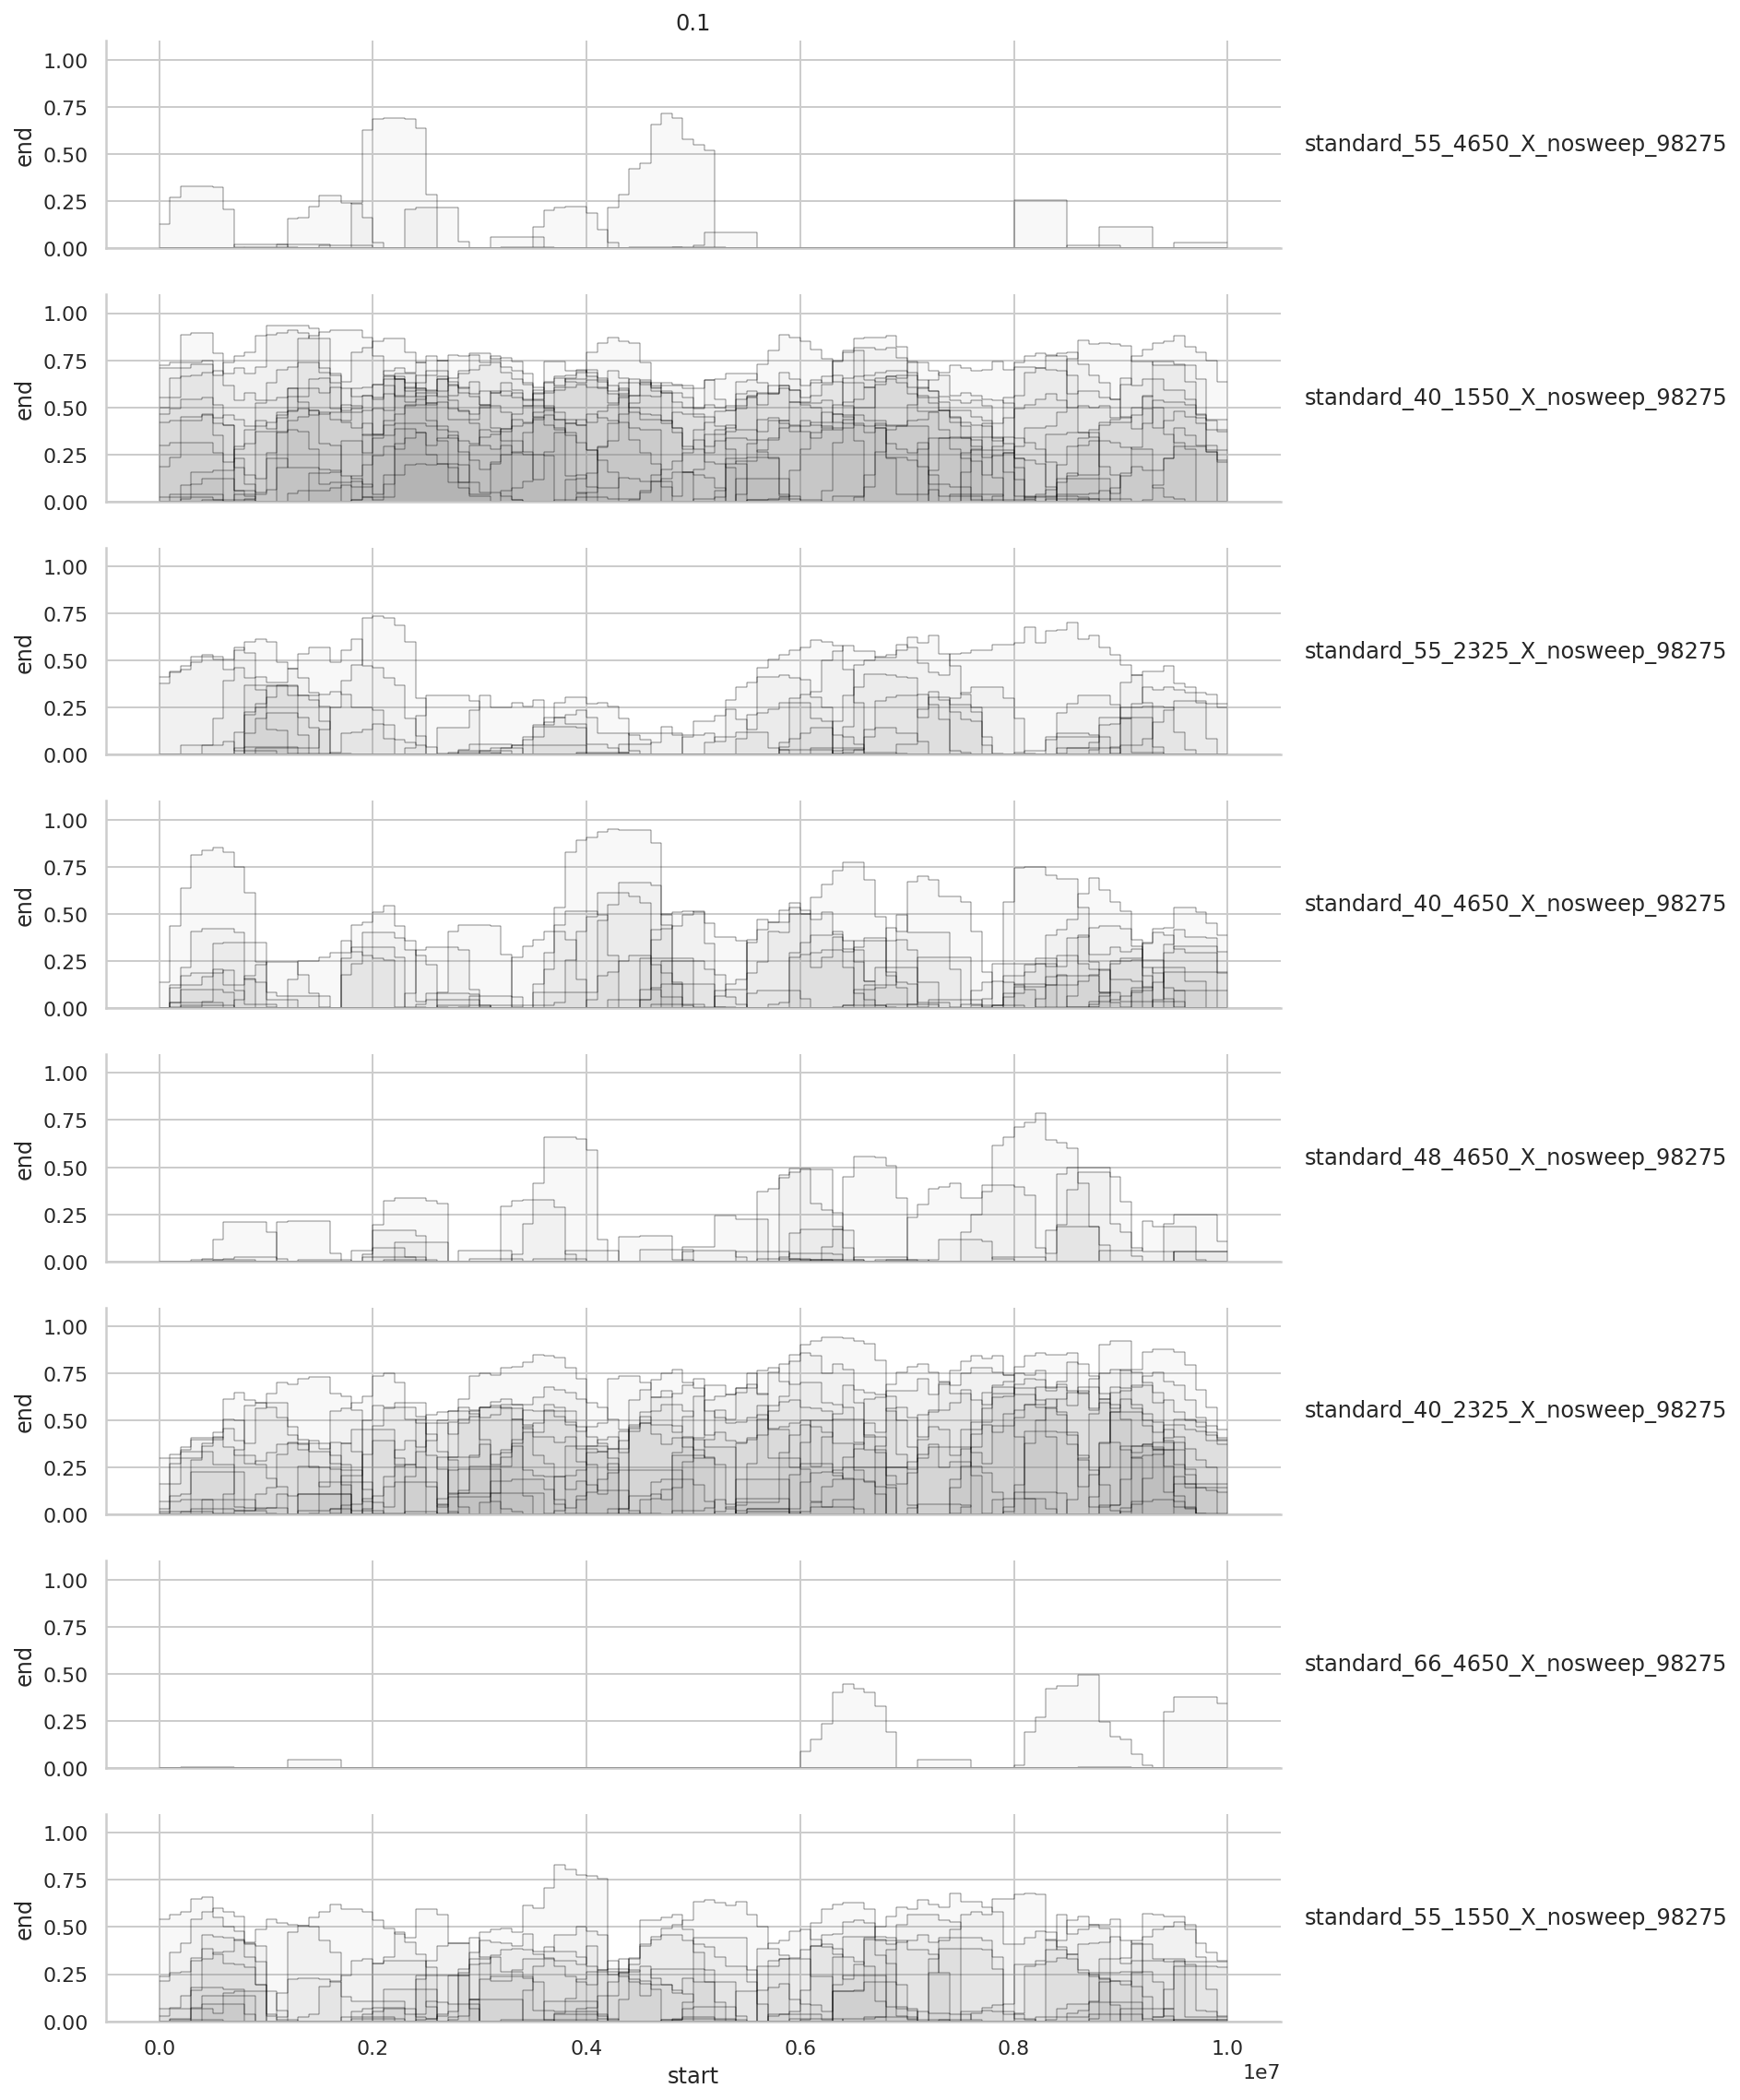

In [44]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
#    plt.plot(x, y, linewidth=0.2, **kwargs)
    plt.ylim((0, 1.1))
    plt.fill_between(x, 0, y, color='gray', alpha=0.05)


with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data, col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



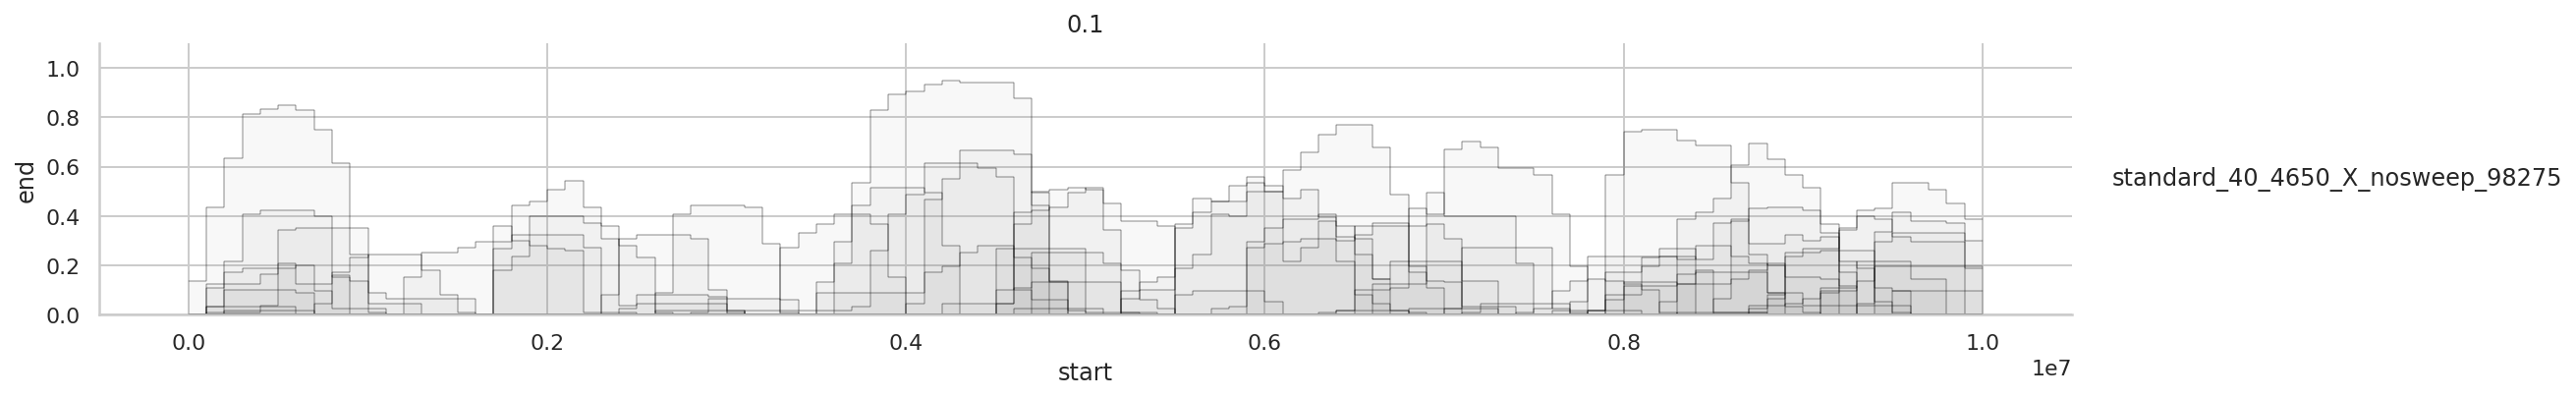

In [45]:
with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.str.startswith('standard_40_4650')],
                      col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=3, aspect=5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



In [46]:
prop_swept_data.simulation.unique()

array(['standard_55_4650_X_nosweep_98275',
       'standard_40_1550_X_nosweep_98275',
       'standard_55_2325_X_nosweep_98275',
       'standard_40_4650_X_nosweep_98275',
       'standard_48_4650_X_nosweep_98275',
       'standard_40_2325_X_nosweep_98275',
       'standard_66_4650_X_nosweep_98275',
       'standard_55_1550_X_nosweep_98275'], dtype=object)

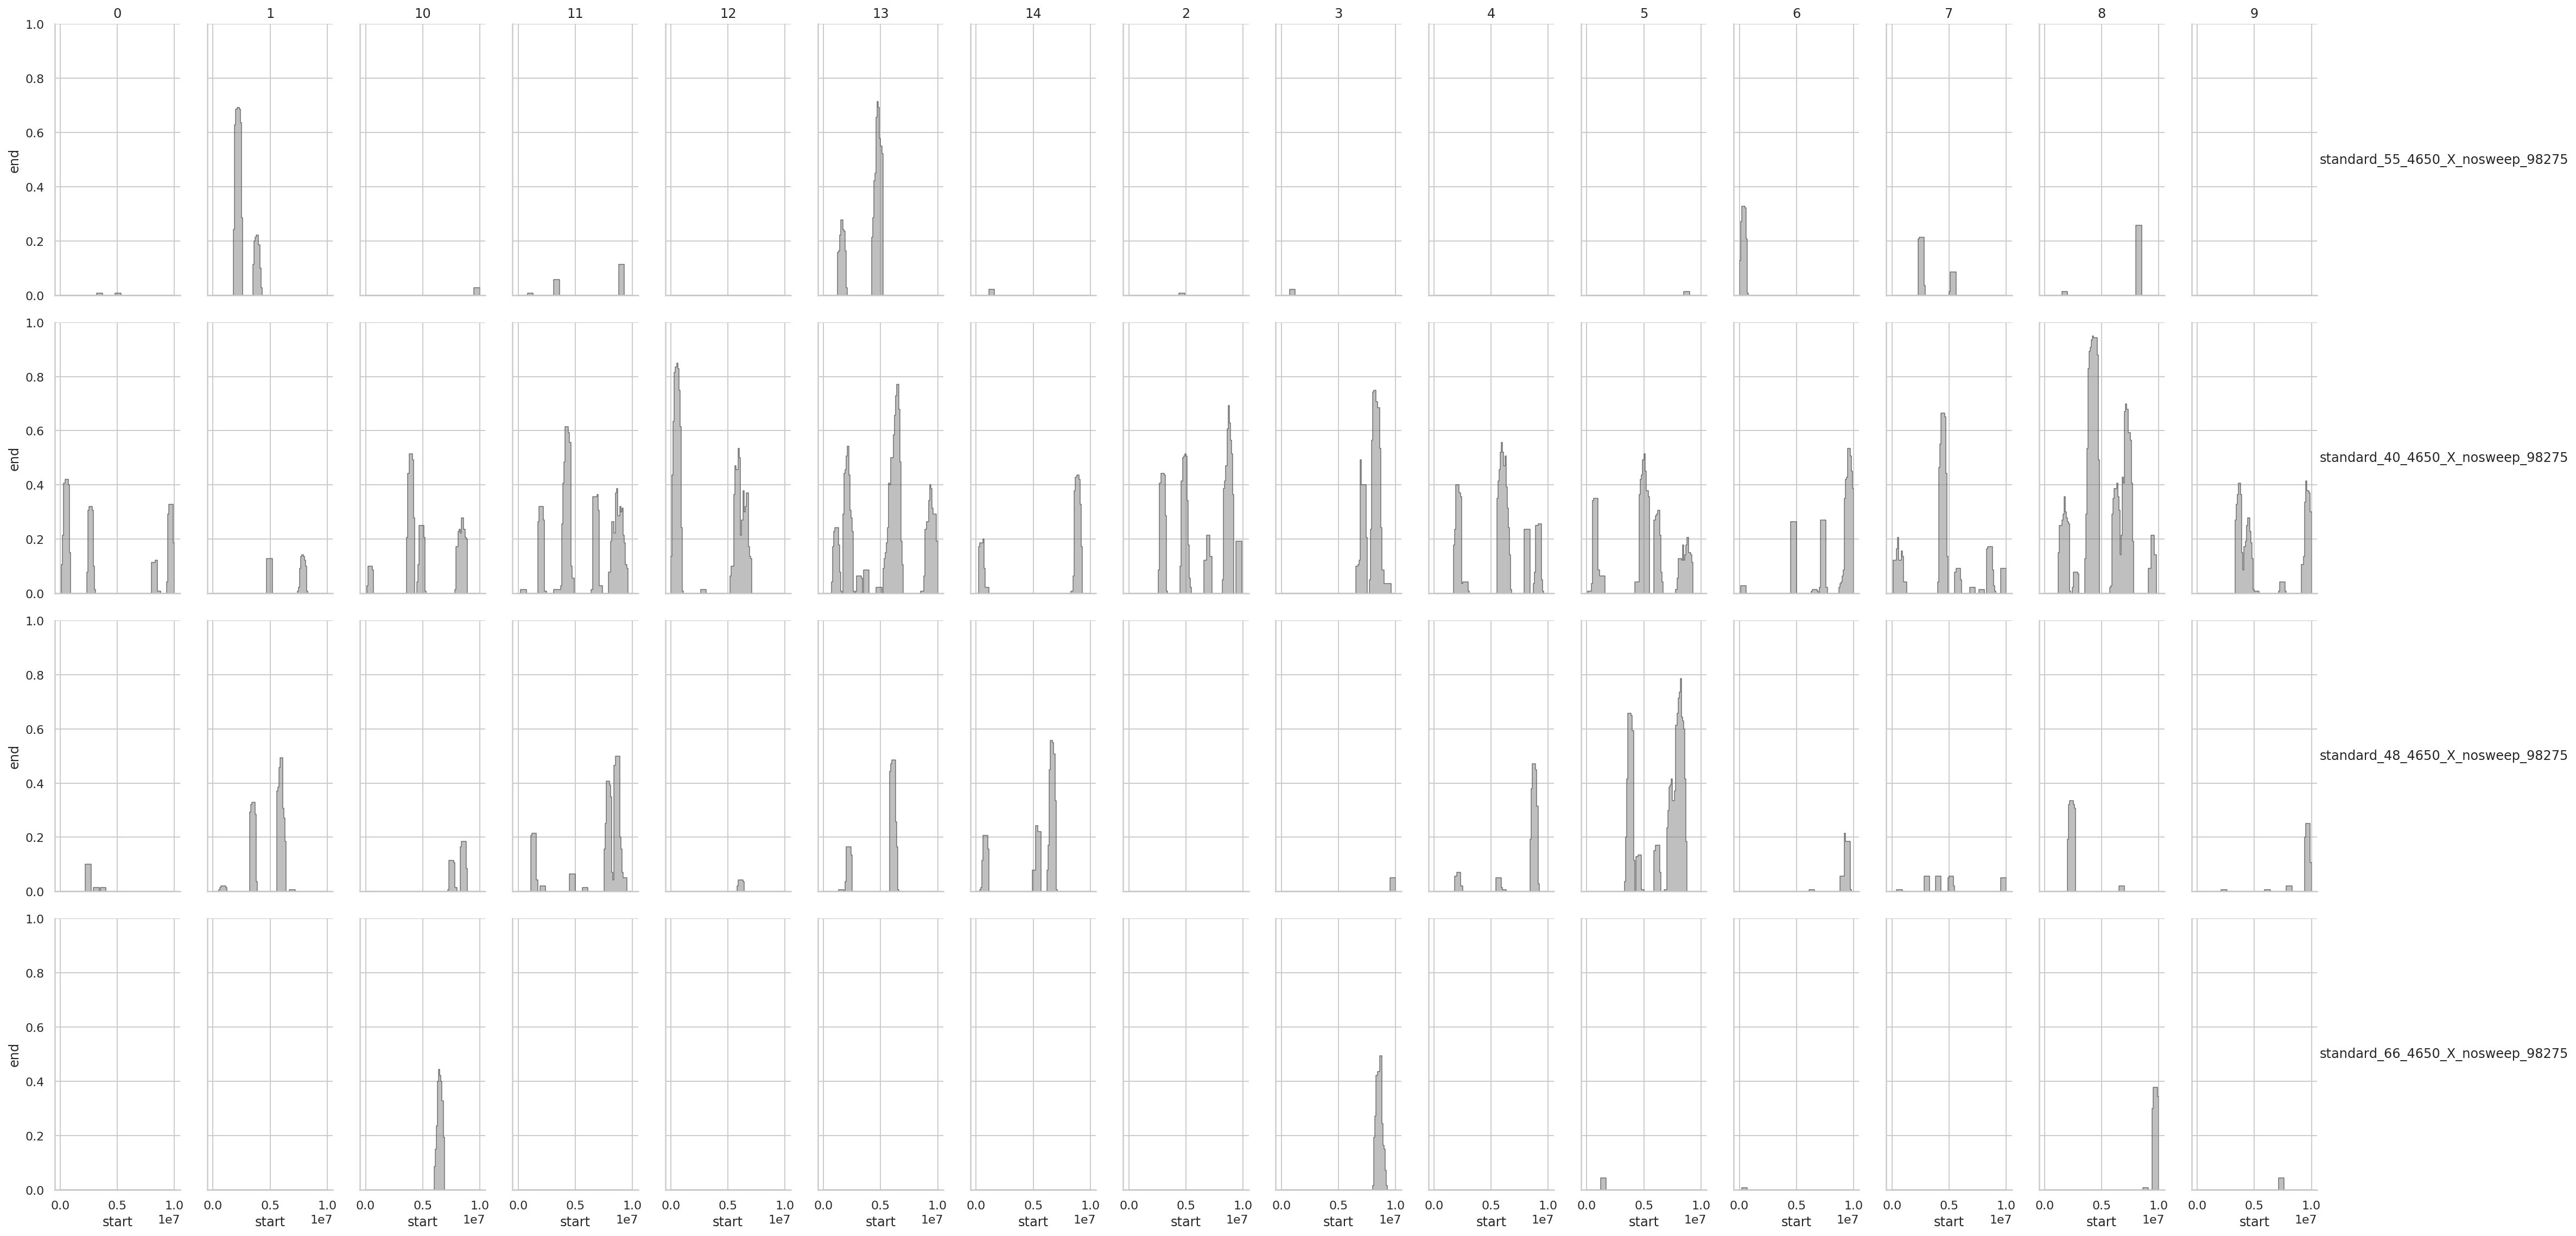

In [47]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
#    plt.plot(x, y, linewidth=0.2, **kwargs)
    plt.ylim((0, 1))
    plt.fill_between(x, 0, y, color='gray', alpha=0.5)

with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.isin(['standard_55_4650_X_nosweep_98275',
                                                                          'standard_40_4650_X_nosweep_98275',
                                                                          'standard_48_4650_X_nosweep_98275',
                                                                          'standard_66_4650_X_nosweep_98275'])],
                      col='replication', row='simulation', sharex=True, sharey=True, margin_titles=True,
                     height=4, aspect=0.5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



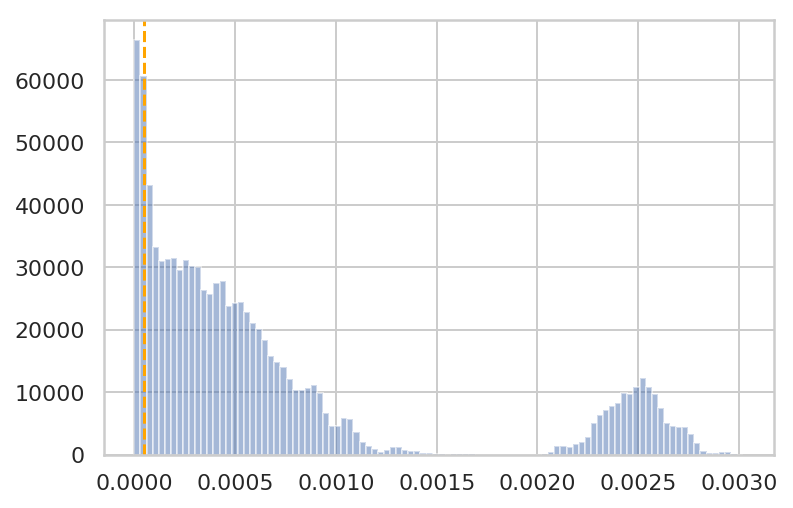

In [48]:
df = pd.read_hdf(str(ag.steps_dir / 'slim/simulations/standard/66/4650/X/nosweep/98275/10/standard_66_4650_X_nosweep_98275_10_0.hdf'))

plt.hist(df.dist, bins=100, alpha=0.5) ;
plt.axvline(5e-5, color='orange', linestyle='dashed') ;


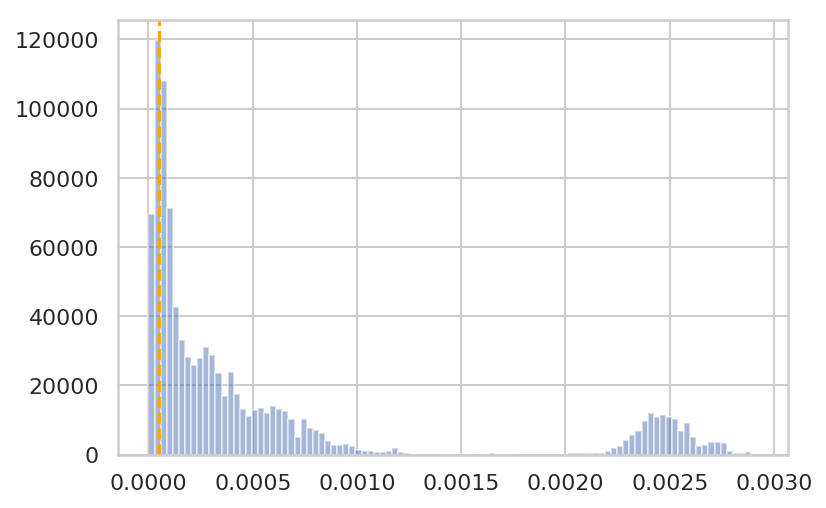

In [49]:
df = pd.read_hdf(str(ag.steps_dir / 'slim/simulations/standard/48/4650/X/nosweep/98275/10/standard_48_4650_X_nosweep_98275_10_0.hdf'))

plt.hist(df.dist, bins=100, alpha=0.5) ;
plt.axvline(5e-5, color='orange', linestyle='dashed');


In [275]:
# s = 'standard_40_4650_X_nosweep_98275_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

# s = 'standard_40_4650_X_nosweep_98275_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

In [276]:
# s = 'nosweep_10000_96551_98965_10000_96206_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

# s = 'nosweep_10000_96551_98965_1000_96206_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

# s = 'nosweep_10000_96954_98563_690_98275_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=200, alpha=0.5) ;

# s = 'nosweep_10000_97356_98160_357_99310_{}'.format(20)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))
# plt.hist(df.dist, bins=100, alpha=0.5) ;


In [ ]:


s = 'nosweep_10000_3448_5861_10000_5171_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=100, alpha=0.5) ;


In [ ]:
s = 'nosweep_10000_3447_5861_1000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;

s = 'nosweep_10000_3448_5861_10000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=200, alpha=0.5) ;


In [ ]:
s = 'nosweep_10000_3447_5861_1000_3102_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=100) ;

In [ ]:
plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    df = pd.read_hdf(f_name_tmpl.format(i))
    plt.hist(df.dist, bins=100)
    plt.axvline(5e-5, color='orange', zorder=0)

In [ ]:
import pyslim, msprime, random
seed = 7
mutation_rate = 1.25e-8
sample_size = 100

trees = pyslim.load(f_name_tmpl.format(0).replace('.hdf', '.trees'))

# Overlay neutral mutations and make bit arrays for each SNP:
sample_ids = sorted(random.sample(list(trees.samples()), sample_size))

trees_sample = trees.simplify(samples=sample_ids, filter_zero_mutation_sites=True, filter_individuals=True)
mutated_trees = msprime.mutate(trees_sample, rate=mutation_rate, random_seed=seed)
# mutated.dump("./sweep_overlaid.trees") 
print(mutated_trees.pairwise_diversity() / mutated_trees.sequence_length)


ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos
plt.figure(figsize=(10,3))
plt.plot(height_for_pos, linewidth=0.5, color='black') ;


trees = pyslim.load(f_name_tmpl.format(1).replace('.hdf', '.trees'))

# Overlay neutral mutations and make bit arrays for each SNP:
sample_ids = sorted(random.sample(list(trees.samples()), sample_size))

trees_sample = trees.simplify(samples=sample_ids, filter_zero_mutation_sites=True, filter_individuals=True)
mutated_trees = msprime.mutate(trees_sample, rate=mutation_rate, random_seed=seed)
# mutated.dump("./sweep_overlaid.trees") 
print(mutated_trees.pairwise_diversity() / mutated_trees.sequence_length)


ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos

plt.plot(height_for_pos, linewidth=0.5, color='red') ;







## Run slim testing to get pairwise distances for testing purposes

In [107]:
from itertools import combinations
import argparse
import random
import subprocess
import re, os, sys
import tempfile
import numpy as np
import pandas as pd
from pandas import DataFrame
import msprime, pyslim

trees_file = "/home/kmt/simons/faststorage/people/kmt/test_slim.trees"

slurm_script = r'''
initialize() {
	initializeTreeSeq();
	initializeMutationRate(0);
	initializeMutationType("m1", 0.5, "f", 0.0);
	initializeGenomicElementType("g1", m1, 1.0);
	initializeGenomicElement(g1, 0, 10e6-1);
	initializeRecombinationRate(1e-8);
}
1 {
	defineConstant("simID", getSeed());
	sim.addSubpop("p1", 10000);
}
50000 {
    sim.treeSeqOutput("OUTFILE");
	sim.simulationFinished();
}
'''.replace('OUTFILE', trees_file)

print(slurm_script)
random.seed(7)

window_size = 100000

# write slim script file with the right output name
slurm_script_file = tempfile.NamedTemporaryFile(mode='w', delete=False)
slurm_script_file.write(slurm_script)
slurm_script_file.close()

# run slim
cmd = '/home/kmt/simons/faststorage/people/kmt/slim {}'.format(slurm_script_file.name)
p = subprocess.Popen(cmd.split(), 
    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = p.communicate()
print(stdout.decode())
print(stderr.decode())


initialize() {
	initializeTreeSeq();
	initializeMutationRate(0);
	initializeMutationType("m1", 0.5, "f", 0.0);
	initializeGenomicElementType("g1", m1, 1.0);
	initializeGenomicElement(g1, 0, 10e6-1);
	initializeRecombinationRate(1e-8);
}
1 {
	defineConstant("simID", getSeed());
	sim.addSubpop("p1", 10000);
}
50000 {
    sim.treeSeqOutput("/home/kmt/simons/faststorage/people/kmt/test_slim.trees");
	sim.simulationFinished();
}

// Initial random seed:
1588181088081

// RunInitializeCallbacks():
initializeTreeSeq();
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 9999999);
initializeRecombinationRate(1e-08);

// Starting run at generation <start>:
1 





In [129]:
mutationrate = 4.3e-10
generationtime = 29

# load trees from slim
ts = pyslim.load(trees_file)

# overlay mutations
mutated_ts = msprime.mutate(ts, rate=mutationrate*generationtime, random_seed=2, keep=True)

2631.1430615333334

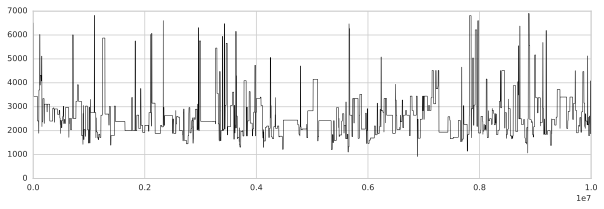

In [131]:
ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos
plt.figure(figsize=(10,3))
plt.plot(height_for_pos, linewidth=0.5, color='black') ;

height_for_pos.mean()

In [114]:
samples = 10

# random indexes for samples
sample_idx = set(random.sample(range(ts.num_individuals), samples))
assert len(sample_idx) == samples

In [115]:
# get the corresponding sample haplotypes
sample = list()
for i, hap in enumerate(mutated_ts.haplotypes()):
    if i in sample_idx:
        sample.append(hap)        

In [117]:
        
# get the positions of each segregating site
positions = [site.position for site in mutated_ts.sites()]  

# make table with sampled haplotypes
table = np.array([list(map(np.int8, hap)) for hap in sample]).transpose()

In [118]:
# turn table into dataframe with positions
df = DataFrame(table, dtype='int8')
df['pos'] = positions

,0,1,2,3,4,5,6,7,8,9,pos
0,0,0,0,0,0,0,0,0,0,0,205.002715
1,0,0,0,0,0,0,0,0,0,0,468.055892
2,0,0,0,0,0,0,0,0,0,0,475.586858
3,0,0,0,0,0,0,0,1,0,0,799.590830
4,1,0,1,0,0,1,0,0,1,1,813.534688


In [119]:
# add a row with zeros for the start of each window so there is at least
# one row in each window
zeros = dict((x, 0) for x in range(samples))
extra_df = pd.DataFrame({'pos': range(0, int(mutated_ts.sequence_length), window_size), **zeros})
df = df.append(extra_df)

,0,1,2,3,4,5,6,7,8,9,pos
95,0,0,0,0,0,0,0,0,0,0,9500000.0
96,0,0,0,0,0,0,0,0,0,0,9600000.0
97,0,0,0,0,0,0,0,0,0,0,9700000.0
98,0,0,0,0,0,0,0,0,0,0,9800000.0
99,0,0,0,0,0,0,0,0,0,0,9900000.0


In [120]:
# make a start column grouping all rows in same window
df['start'] = ((df.pos // window_size) * window_size).astype('uint32')
df.drop('pos', axis=1, inplace=True)
df.set_index('start', inplace=True)

def pw_dist(df):
    "computes differences bewteen all pairs in a window"
    pairs = list(combinations(df.columns, 2))
    site_diffs = [np.bitwise_xor(df[p[0]], df[p[1]]) for p in pairs]
    return pd.concat(site_diffs, axis=1, keys=pairs).sum()

# make a dataframe with distance for each pair
pw_dist_df = (
    df
    .groupby('start')
    .apply(pw_dist)
    .reset_index()
    .melt(id_vars=['start'], var_name=['indiv_1', 'indiv_2'], value_name='dist')
    )

,start,indiv_1,indiv_2,dist
0,0,0,1,74
1,100000,0,1,67
2,200000,0,1,57
3,300000,0,1,61
4,400000,0,1,34


In [121]:
# compute proper distance as number of diffs divided by window size
pw_dist_df['dist'] /= window_size

# add end column
pw_dist_df.insert(loc=1, column='end', value=pw_dist_df.start + window_size)

# convert indiv labels from object to int and and write hdf
pw_dist_df['indiv_1'] = pw_dist_df['indiv_1'].astype('uint16')
pw_dist_df['indiv_2'] = pw_dist_df['indiv_2'].astype('uint16')
#pw_dist_df.to_hdf(args.hdf_file, 'df', format='table', mode='w')

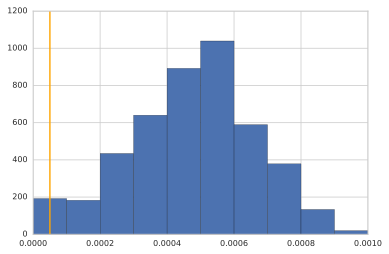

In [127]:
plt.hist(pw_dist_df.dist) 
plt.axvline(5e-5, color='orange') ;